<h1>Create initial images to be used in feather tutorial</h1>

In [1]:
import pkg_resources, os
casa_data_dir = pkg_resources.resource_filename("casadata", "__data__")
rc_file = open(os.path.expanduser("~/.casarc"), "a+")  # append mode
rc_file.write("\nmeasures.directory: " + casa_data_dir)
rc_file.close()

In [2]:
# download base images
from graphviper.utils.data import download

download("feather_sim_sd_c1_pI.im")
download("feather_sim_vla_c1_pI.im")

[2024-03-27 14:57:09,636]     INFO  graphviper:  File exists: feather_sim_sd_c1_pI.im 
[2024-03-27 14:57:09,639]     INFO  graphviper:  File exists: feather_sim_vla_c1_pI.im 


In [3]:
# from graphviper.dask.client import local_client
# viper_client = local_client(cores=4, memory_limit="4GB")

# import dask
# dask.config.set(scheduler="synchronous")
# dask.config.set(scheduler="threads")

<h2>Inputs to be specified by user</h2>

In [4]:
# ra, dec size, should not exceed 4096 x 4096
imsize = [2048, 2048]

# number of channels
nchan = 512

# currently, there is only one polarization and it is I

In [5]:
from xradio.image.image import (
    make_empty_sky_image
)
import numpy as np
rad_per_arcsec = np.pi/180/3600
skel_xds = make_empty_sky_image(
    phase_center=[0.6, -0.2],
    image_size=imsize,
    cell_size=[15*rad_per_arcsec, 15*rad_per_arcsec],
    chan_coords=np.linspace(1.4e9, 1.5e9, nchan),
    pol_coords=["I"],
    time_coords=[0],
)
skel_xds

<xarray.Dataset>
Dimensions:          (time: 1, polarization: 1, frequency: 512, l: 2048, m: 2048)
Coordinates:
  * time             (time) float64 0.0
  * polarization     (polarization) <U1 'I'
  * frequency        (frequency) float64 1.4e+09 1.4e+09 ... 1.5e+09 1.5e+09
    velocity         (frequency) float64 1.036e+07 1.032e+07 ... -1.032e+07
  * l                (l) float64 0.07447 0.07439 0.07432 ... -0.07432 -0.07439
  * m                (m) float64 -0.07447 -0.07439 -0.07432 ... 0.07432 0.07439
    right_ascension  (l, m) float64 0.6774 0.6774 0.6774 ... 0.5249 0.5249 0.525
    declination      (l, m) float64 -0.274 -0.2739 -0.2738 ... -0.1251 -0.125
Data variables:
    *empty*
Attributes:
    direction:        {'reference': {'type': 'sky_coord', 'frame': 'FK5', 'eq...
    active_mask:      
    beam:             None
    object_name:      
    obsdate:          {'type': 'time', 'scale': 'UTC', 'format': 'MJD', 'valu...
    observer:         Karl Jansky
    pointing_center:  {'value': [0.6, -0.2], 'initial': True}
    description:      
    telescope:        {'name': 'ALMA', 'position': {'type': 'position', 'elli...
    history:          None

In [6]:
from xradio.image import read_image

sel_dict = {}
if imsize[0] < 4096:
    blc = 2048 - imsize[0]//2
    l_slice = slice(blc, blc + imsize[0])
    sel_dict["l"] = l_slice
if imsize[1] < 4096:
    blc = 2048 - imsize[1]//2
    m_slice = slice(blc, blc + imsize[1])
    sel_dict["m"] = m_slice
xds_sd_temp = read_image("feather_sim_sd_c1_pI.im").isel(sel_dict)
xds_sd_temp

Successful readonly open of default-locked table feather_sim_sd_c1_pI.im: 1 columns, 1 rows
[2024-03-27 14:57:25,257]     INFO  graphviper:  J2000 found as native reference frame in CASA image This corresponds to FK5(equinox="J2000") in astropy. Metadata will be written appropriately 


<xarray.Dataset>
Dimensions:          (time: 1, polarization: 1, frequency: 1, l: 2048, m: 2048)
Coordinates:
  * time             (time) float64 5.154e+04
  * polarization     (polarization) <U1 'I'
  * frequency        (frequency) float64 1.414e+09
    velocity         (frequency) float64 1.352e+06
  * l                (l) float64 0.07447 0.07439 0.07432 ... -0.07432 -0.07439
  * m                (m) float64 -0.07447 -0.07439 -0.07432 ... 0.07432 0.07439
    right_ascension  (l, m) float64 0.07474 0.07474 0.07474 ... 6.209 6.209
    declination      (l, m) float64 -0.07454 -0.07446 ... 0.07439 0.07446
Data variables:
    sky              (time, polarization, frequency, l, m) float32 dask.array<chunksize=(1, 1, 1, 2048, 2048), meta=np.ndarray>
Attributes:
    direction:        {'reference': {'frame': 'FK5', 'type': 'sky_coord', 'eq...
    telescope:        {'name': 'ALMA', 'position': {'type': 'position', 'elli...
    obsdate:          {'type': 'time', 'scale': 'UTC', 'units': 'd', 'value':...
    pointing_center:  {'value': array([0., 0.]), 'initial': True}
    observer:         Karl Jansky
    object_name:      
    beam:             {'major': {'type': 'quantity', 'value': 0.0040724349213...
    user:             {}
    active_mask:      None
    description:      None
    history:          <xarray.Dataset>\nDimensions:    (row: 6)\nCoordinates:...

In [7]:
xds_int_temp = read_image("feather_sim_vla_c1_pI.im").isel(sel_dict)
#xds_int_temp
xds_int_temp

Successful readonly open of default-locked table feather_sim_vla_c1_pI.im: 1 columns, 1 rows
[2024-03-27 14:57:30,389]     INFO  graphviper:  J2000 found as native reference frame in CASA image This corresponds to FK5(equinox="J2000") in astropy. Metadata will be written appropriately 


<xarray.Dataset>
Dimensions:          (time: 1, polarization: 1, frequency: 1, l: 2048, m: 2048)
Coordinates:
  * time             (time) float64 5.876e+04
  * polarization     (polarization) <U1 'I'
  * frequency        (frequency) float64 1.414e+09
    velocity         (frequency) float64 2.119e+05
  * l                (l) float64 0.07447 0.07439 0.07432 ... -0.07432 -0.07439
  * m                (m) float64 -0.07447 -0.07439 -0.07432 ... 0.07432 0.07439
    right_ascension  (l, m) float64 0.07474 0.07474 0.07474 ... 6.209 6.209
    declination      (l, m) float64 -0.07454 -0.07446 ... 0.07439 0.07446
Data variables:
    sky              (time, polarization, frequency, l, m) float32 dask.array<chunksize=(1, 1, 1, 2048, 2048), meta=np.ndarray>
Attributes:
    direction:        {'reference': {'frame': 'FK5', 'type': 'sky_coord', 'eq...
    telescope:        {'name': 'VLA', 'position': {'type': 'position', 'ellip...
    obsdate:          {'type': 'time', 'scale': 'UTC', 'units': 'd', 'value':...
    pointing_center:  {'value': array([0., 0.]), 'initial': False}
    observer:         CASA simulator
    object_name:      fake
    beam:             {'major': {'type': 'quantity', 'value': 0.0003175938332...
    user:             {'INSTRUME': 'VLA', 'distance': 0.0, 'mpiprocs': 1, 'ch...
    active_mask:      None
    description:      None
    history:          <xarray.Dataset>\nDimensions:    (row: 98)\nCoordinates...

In [8]:
import dask.array as da
import xarray as xr
dm = skel_xds.sizes
data = da.zeros(
    [
        dm["time"], dm["polarization"],
        dm["frequency"], dm["l"], dm["m"]
    ], dtype=np.float32
)
zeros = xr.DataArray(data=data, coords=skel_xds.coords, dims=skel_xds.dims)
zeros

<xarray.DataArray 'zeros_like-94624c848eabf6639dc9a9d05146f106' (time: 1,
                                                                 polarization: 1,
                                                                 frequency: 512,
                                                                 l: 2048,
                                                                 m: 2048)>
dask.array<zeros_like, shape=(1, 1, 512, 2048, 2048), dtype=float32, chunksize=(1, 1, 322, 322, 322), chunktype=numpy.ndarray>
Coordinates:
  * time             (time) float64 0.0
  * polarization     (polarization) <U1 'I'
  * frequency        (frequency) float64 1.4e+09 1.4e+09 ... 1.5e+09 1.5e+09
    velocity         (frequency) float64 1.036e+07 1.032e+07 ... -1.032e+07
  * l                (l) float64 0.07447 0.07439 0.07432 ... -0.07432 -0.07439
  * m                (m) float64 -0.07447 -0.07439 -0.07432 ... 0.07432 0.07439
    right_ascension  (l, m) float64 0.6774 0.6774 0.6774 ... 0.5249 0.5249 0.525
    declination      (l, m) float64 -0.274 -0.2739 -0.2738 ... -0.1251 -0.125

In [9]:
import copy

sky = xr.DataArray(
    zeros.copy(), coords=skel_xds.coords, dims=skel_xds.dims
)
for i in (0, 1):
    print(i)
    xds = copy.deepcopy(skel_xds)
    xds["sky"] = sky.copy()
    for j in range(0, nchan, 16):
        min_chan = j
        max_chan = min(j+16, nchan)
        fx = xds_sd_temp if i == 0 else xds_int_temp
        print(id(fx))
        xds["sky"][{"frequency": slice(min_chan, max_chan)}] = (
            fx["sky"].values
        )
        print(f"xds {id(xds)}")
    if i == 0:
        xds_sd = xds
        xds_sd.attrs["beam"] = copy.deepcopy(xds_sd_temp.attrs["beam"])
    else:
        xds_int = xds
        xds_int.attrs["beam"] = copy.deepcopy(xds_int_temp.attrs["beam"])
    
xds_sd

0
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942863017840
123942863016608
xds 123942

<xarray.Dataset>
Dimensions:          (time: 1, polarization: 1, frequency: 512, l: 2048, m: 2048)
Coordinates:
  * time             (time) float64 0.0
  * polarization     (polarization) <U1 'I'
  * frequency        (frequency) float64 1.4e+09 1.4e+09 ... 1.5e+09 1.5e+09
    velocity         (frequency) float64 1.036e+07 1.032e+07 ... -1.032e+07
  * l                (l) float64 0.07447 0.07439 0.07432 ... -0.07432 -0.07439
  * m                (m) float64 -0.07447 -0.07439 -0.07432 ... 0.07432 0.07439
    right_ascension  (l, m) float64 0.6774 0.6774 0.6774 ... 0.5249 0.5249 0.525
    declination      (l, m) float64 -0.274 -0.2739 -0.2738 ... -0.1251 -0.125
Data variables:
    sky              (time, polarization, frequency, l, m) float32 dask.array<chunksize=(1, 1, 322, 322, 322), meta=np.ndarray>
Attributes:
    direction:        {'reference': {'type': 'sky_coord', 'frame': 'FK5', 'eq...
    active_mask:      
    beam:             {'major': {'type': 'quantity', 'value': 0.0040724349213...
    object_name:      
    obsdate:          {'type': 'time', 'scale': 'UTC', 'format': 'MJD', 'valu...
    observer:         Karl Jansky
    pointing_center:  {'value': [0.6, -0.2], 'initial': True}
    description:      
    telescope:        {'name': 'ALMA', 'position': {'type': 'position', 'elli...
    history:          None

In [10]:
bytes_in_dtype = {'float32':4,'double':8,'complex':16}

#chunking_dims_sizes = {'frequency':int_xds["sky"].sizes['frequency']}
#memory_singleton_chunk = 3*np.product(np.array(list(chunking_dims_sizes.values())))
xds_sd['sky'].sizes['frequency']

singleton_chunk_sizes = dict(xds_sd['sky'].sizes) 
print(singleton_chunk_sizes)
del singleton_chunk_sizes['frequency'] #Remove dimensions that will be chuncked on.
print(singleton_chunk_sizes)
fudge_factor = 1.1
n_images_in_memory = 3.0
memory_singleton_chunk = n_images_in_memory*np.product(np.array(list(singleton_chunk_sizes.values())))*fudge_factor*bytes_in_dtype[str(xds_sd['sky'].dtype)]/(1024**3)


memory_singleton_chunk

{'time': 1, 'polarization': 1, 'frequency': 512, 'l': 2048, 'm': 2048}
{'time': 1, 'polarization': 1, 'l': 2048, 'm': 2048}


0.051562500000000004

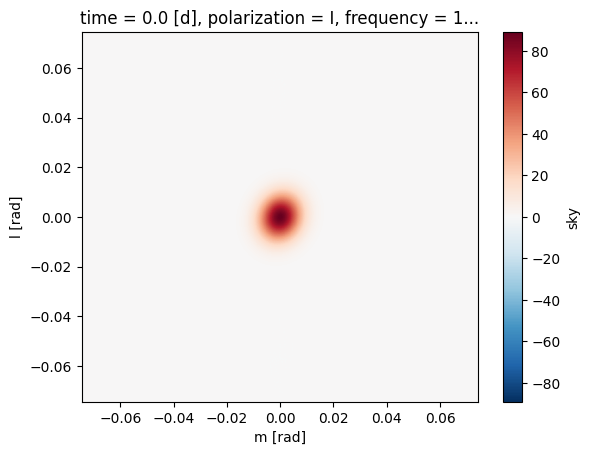

In [11]:
xds_sd["sky"].sel(polarization="I").isel(frequency=0, time=0).plot()

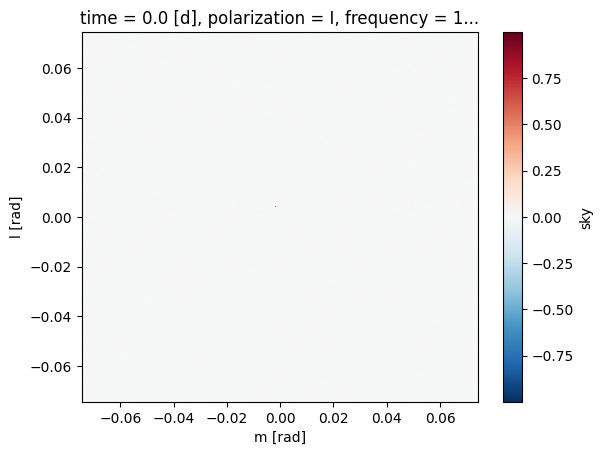

In [12]:
# This is a point source, so may not be obvious
# in this plot
xds_int["sky"].sel(polarization="I").isel(frequency=0, time=0).plot()

In [13]:
# These are the input images for the next step

import os, shutil

from xradio.image import write_image
for xds, outfile in zip([xds_sd, xds_int], ["sd.zarr", "int.zarr"]):
    if os.path.exists(outfile):
        shutil.rmtree(outfile)
    write_image(xds, outfile, "zarr")
    print(f"Wrote {outfile}")

Wrote sd.zarr
Wrote int.zarr
